#### Student Name: Adi Dereviani, Ron Dagani

---


#### Student ID: 305674731, 318170917


## Overview
### Due December 1st

Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. YOU MUST SUBMIT EACH HOMEWORK, even if your partner submits!

Upload your completed assignment on moodle.

In [1]:
# If you're collaboraing with a classmate, please fill in the following:

collaboration = {
     "305674731":"318170917"
}

In [2]:
! pip install librosa

# Understanding Sound

For this portion of the assignment, you will load your unique wav file from
https://drive.google.com/drive/folders/122l65r1FZcHyRt4bfjIi4HRg_mVLKc1T?usp=sharing

Please enter your first and last name, like below, to get the name of your audio file.


In [3]:
your_firstname = "Adi"
your_lastname = "Dereviani"
print(f"{your_firstname[0]}.{your_lastname}.wav")

A.Dereviani.wav


Your task is to listen and examine your file and try to recreate it with sin waves.

Hints :)
- The length of each frequency used is 3-7 seconds
- Each frequency is set to start at exactly the start of a second
- The amplitudes used are [0.5, 1, 1.5, 2, 2.5]
- Think of all we learned in class (sample rate, wave forms, adding waves, spectrogram, etc.)
- These may be helpful for you
 - http://librosa.org/doc/0.8.1/generated/librosa.display.waveplot.html
  - https://librosa.org/doc/main/generated/librosa.stft.html

In [4]:
import librosa
import librosa.display as dsp

from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np

### Modify the line below with your WAV file:
y, sample_rate = librosa.load("A.Dereviani.wav")

Audio(data=y,rate=sample_rate)

In [5]:
from scipy.io.wavfile import write

##### Question 1 [15 points]
Reconstruct your wav file using sin waves. Use whatever approach you can think of. Google is your friend if you need it.

Make sure to play your version and also show the difference between the original and your reconstruction.

Sample Rate: 22050, Audio Length: 20.000 seconds


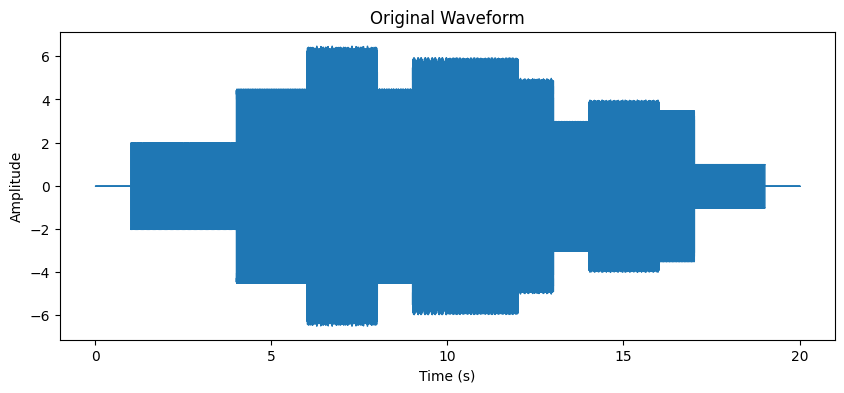

In [6]:
print(f"Sample Rate: {sample_rate}, Audio Length: {len(y)/sample_rate:.3f} seconds")
plt.figure(figsize=(10, 4))
dsp.waveshow(y, sr=sample_rate)
plt.title("Original Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


Sample Rate: 22050, Audio Length: 20.000 seconds


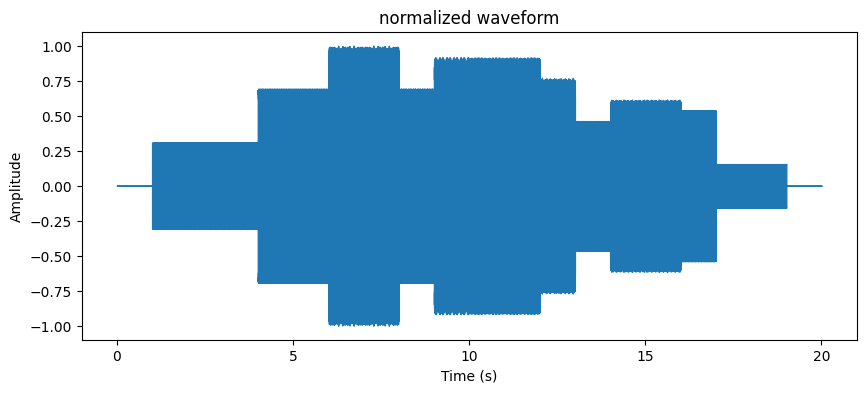

In [7]:
y = y / max(max(y),-min(y)) #normalization
print(f"Sample Rate: {sample_rate}, Audio Length: {len(y)/sample_rate:.3f} seconds")
plt.figure(figsize=(10, 4))
dsp.waveshow(y, sr=sample_rate)
plt.title("normalized waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [8]:
sound_time = 20

In [9]:
def get_amplitudes_frequencies(y, sample_rate):
    frequencies_amplitudes = []
    threshold = 5

    for i in range(sound_time):
        # Extract a segment of the signal
        start_idx = sample_rate * i
        end_idx = sample_rate * (i + 1)
        segment = y[start_idx:end_idx]

        # Perform FFT on the segment
        fft_result = np.fft.rfft(segment)
        frequency_values = np.fft.rfftfreq(segment.size, d=1.0 / sample_rate)

        # Map frequencies to amplitudes above the threshold
        frequency_amplitude_map = {
            freq: amp for freq, amp in zip(frequency_values, np.abs(fft_result)) if amp > threshold
        }

        # Ensure there is at least one entry in the map
        if not frequency_amplitude_map:
            frequency_amplitude_map[0.0] = 0.0

        frequencies_amplitudes.append(frequency_amplitude_map)

    return frequencies_amplitudes

frequencies_amplitudes = get_amplitudes_frequencies(y, sample_rate)

# Extract all unique frequencies from frequencies_amplitudes
unique_frequencies = sorted(set(freq for freq_amp in frequencies_amplitudes for freq in freq_amp.keys()))
print(f"Unique frequencies({len(unique_frequencies)}): {unique_frequencies}")


Unique frequencies(8): [0.0, 830.0, 1272.0, 1539.0, 1612.0, 2628.0, 2673.0, 3896.0]


In [10]:
def create_window(start_time, duration, sample_rate, amplitude):
    # Calculate total samples and initialize arrays
    total_samples = sound_time * sample_rate
    signal_array = np.zeros(total_samples)

    # Calculate start and duration in samples
    start_sample = int(start_time * sample_rate)
    end_sample = start_sample + int(duration * sample_rate)

    # Set the active range to the specified amplitude
    signal_array[start_sample:end_sample] = amplitude

    return signal_array, start_time, duration

In [11]:
def generate_sine_wave(frequency, duration, sample_rate):
    total_samples = sound_time * sample_rate
    time_array = np.arange(total_samples)
    return np.sin(2 * np.pi * frequency * time_array / sample_rate)

In [12]:
def create_audio_mixture(sample_rate):
    # Initialize variables
    signal_components = []
    total_signal = np.zeros(int(sound_time * sample_rate))  # Pre-allocate total signal array
    duration = 1
    start_time = 0

    # Process each time index in the frequency-amplitude data
    for time_index, freq_amp_map in enumerate(frequencies_amplitudes):
        # Extract frequencies and amplitudes for the current time index
        frequencies = list(freq_amp_map.keys())
        amplitudes = list(freq_amp_map.values())

        # Loop through all frequencies and amplitudes at this time index
        for freq, amp in zip(frequencies, amplitudes):
            # Create window and generate signal
            window, start, length = create_window(start_time, duration, sample_rate, amp)
            signal = generate_sine_wave(freq, duration, sample_rate) * window

            # Add signal to the total signal
            total_signal += signal

            # Record the signal component details
            signal_components.append((freq, start, length))

        # Increment start time for the next time index
        start_time += 1

    return total_signal, signal_components


In [13]:
# Generate the audio mixture
mixture, fs = create_audio_mixture(sample_rate)
mixture = mixture / max(max(mixture), -min(mixture)) # Normalize

In [14]:
def calculate_reconstruction_error(original, reconstructed):
    error = np.sqrt(np.mean((original - reconstructed) ** 2))
    return error

In [15]:
def plot_signals_comparison(original, reconstructed, sample_rate):
    """
    Plot the original and reconstructed signals on the same graph.

    Args:
    original (numpy array): The original audio signal.
    reconstructed (numpy array): The reconstructed audio signal.
    sample_rate (int): The sampling rate of the audio signals.
    """
    time = np.linspace(0, len(original) / sample_rate, len(original))

    plt.figure(figsize=(12, 6))
    plt.plot(time, original, label="Original", alpha=0.2)
    plt.plot(time, reconstructed, label="Reconstructed", alpha=0.2)
    plt.title("Original vs Reconstructed Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [16]:
def plot_individual_frequencies(signal_info, sample_rate):
    """
    Plot individual sine waves for each frequency component in the reconstruction.

    Args:
    signal_info (list of tuples): List of tuples containing frequency, start time, and duration.
    sample_rate (int): The sampling rate of the audio signals.
    """
    plt.figure(figsize=(12, 6))
    for freq, start, length in signal_info:
        t = np.linspace(start, start + length, int(length * sample_rate), endpoint=False)
        sine_wave = np.sin(2 * np.pi * freq * t)
        plt.plot(t, sine_wave, label=f"Frequency {freq} Hz")

    plt.title("Individual Frequency Components")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    # plt.legend()
    plt.show()

In [17]:
def plot_frequency_spectra(original, reconstructed, sample_rate):
    """
    Plot the frequency spectra of the original and reconstructed signals.

    Args:
    original (numpy array): The original audio signal.
    reconstructed (numpy array): The reconstructed audio signal.
    sample_rate (int): The sampling rate of the audio signals.
    """
    original_fft = np.fft.rfft(original)
    reconstructed_fft = np.fft.rfft(reconstructed)
    freqs = np.fft.rfftfreq(len(original), 1 / sample_rate)

    plt.figure(figsize=(12, 6))
    plt.plot(freqs, np.abs(original_fft), label="Original", alpha=0.7)
    plt.plot(freqs, np.abs(reconstructed_fft), label="Reconstructed", alpha=0.7)
    plt.title("Frequency Spectrum Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [18]:
def verify_frequency_timing(frequencies_amplitudes, sample_rate):
    """
    Compare identified frequencies and timings against time segments.

    Args:
    frequencies_amplitudes (list of dicts): Identified frequencies and amplitudes over time.
    sample_rate (int): The sampling rate of the audio signals.
    """
    times = np.arange(len(frequencies_amplitudes))  # Time segments (seconds)

    plt.figure(figsize=(12, 6))
    for t, freq_amplitudes in enumerate(frequencies_amplitudes):
        for freq in freq_amplitudes.keys():
            plt.scatter(t, freq, color='red', alpha=0.6, label=f"Freq: {freq} Hz" if t == 0 else "")

    plt.title("Frequency Timing Verification")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

In [19]:
# Calculate RMSE between the original and reconstructed signals
reconstruction_error = calculate_reconstruction_error(y, mixture)
print(f"Reconstruction Error (RMSE): {reconstruction_error:.5f}")

Reconstruction Error (RMSE): 0.00000


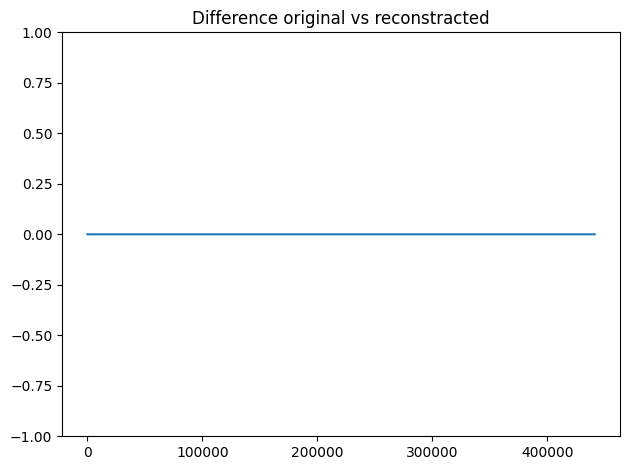

In [20]:
diff = y - mixture

plt.title("Difference original vs reconstracted")
plt.plot(diff)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

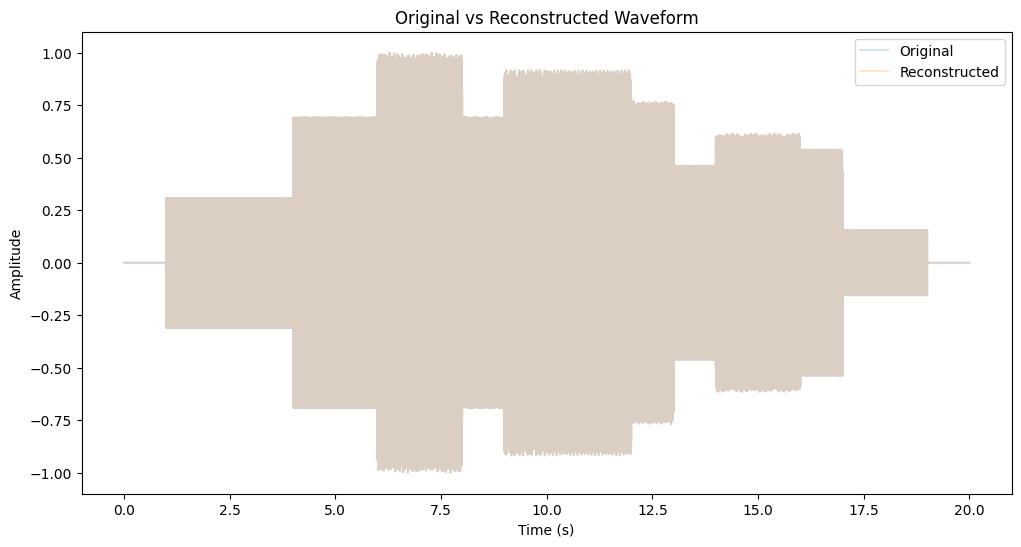

In [21]:
# Plot the original and reconstructed signals on the same graph
plot_signals_comparison(y, mixture, sample_rate)

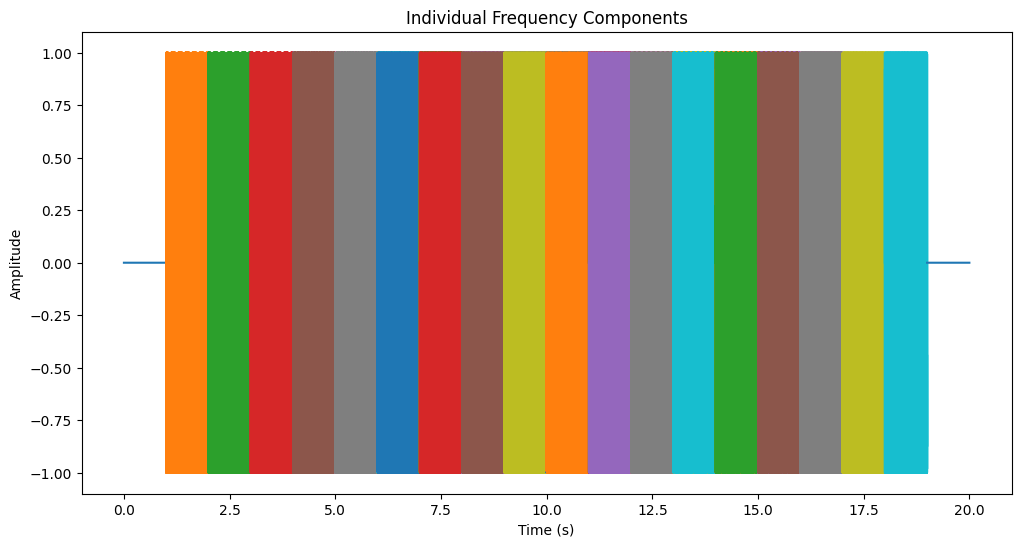

In [22]:
# Visualize individual sine wave components for each frequency
plot_individual_frequencies(fs, sample_rate)

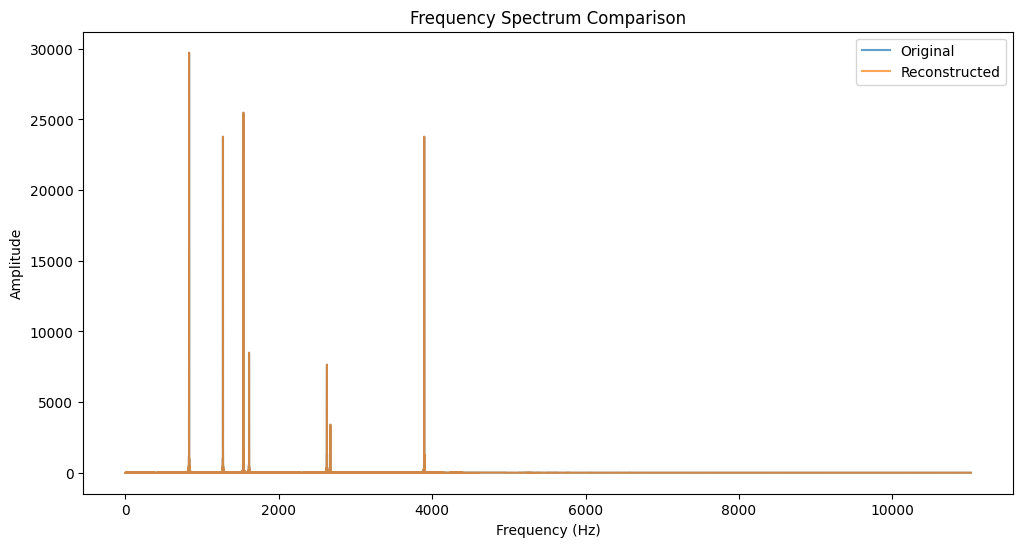

In [23]:
# Compare the frequency spectra of the original and reconstructed signals
plot_frequency_spectra(y, mixture, sample_rate)

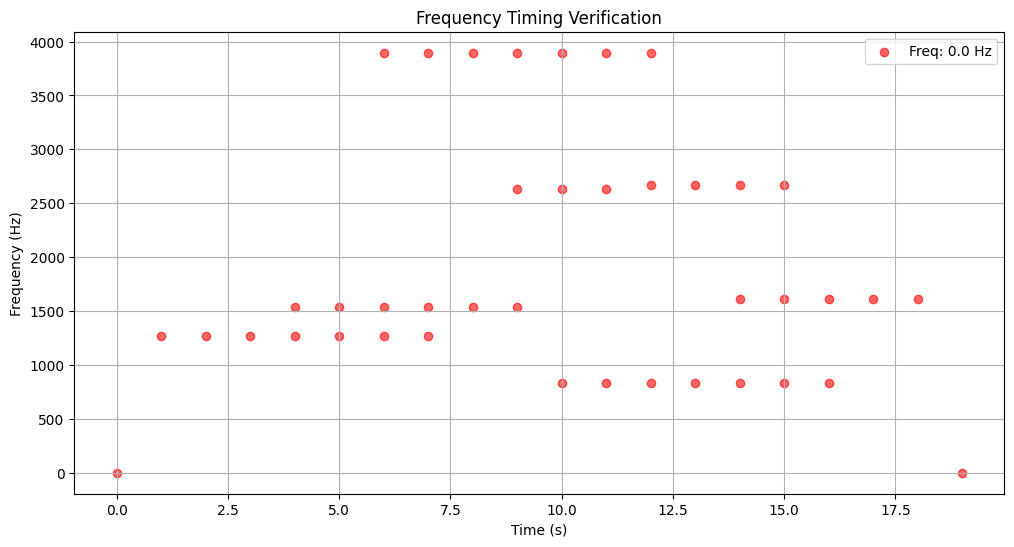

In [24]:
# Verify identified frequencies and their timings on the spectrogram
verify_frequency_timing(frequencies_amplitudes, sample_rate)


##### Question 2 [10 points]
Explain the logic you used to reconstruct the wav file. How did you find the frequencies? How did you figure out where they start and end?
How well did you do?

1. **Explain the logic you used to reconstruct the WAV file**:  
  We reconstructed the .wav file by identifying its dominant frequencies and amplitudes over time using FFT (Fast Fourier Transform).

  To improve accuracy, we used non-overlapping one-second segments of the audio. For each segment, we transformed the waveform into the frequency domain using FFT, extracted the primary frequency components and their amplitudes, and used these values to generate sine waves. The sine waves were combined to recreate the original audio signal.

2. **How did you find the frequencies?**  
  For each second of the signal, we applied FFT to analyze its frequency content. We filtered the results to keep only the frequencies with amplitudes above a predefined threshold. This ensured that we focused on the dominant frequencies that shaped the audio signal.


3. **How did you figure out where they start and end?**  
   we assumed that each frequency started and ended at whole seconds. We analyzed the audio in non-overlapping one-second windows, identifying the frequencies and amplitudes present in each segment.

4. **How well did you do?**  
  The reconstructed waveform was visually and numerically similar to the original, with minor differences. The average difference between the original and reconstructed signals was small, as evidenced by a low RMSE (Root Mean Square Error).
  
  Listening to the reconstructed audio, it sounded very close to the original, though some finer details were missing.
  Visual comparisons between the original and reconstructed waveforms highlighted a strong similarity, especially in capturing the dominant frequencies.


  Overall, we believe the reconstruction was accurate and provided a faithful approximation of the original audio.



##### Question 3 [15 points]
Show some of your work on how you reconstructed the wav file. Show some actual code you used in understanding what the file is composed of? Visuals are nice.


In [25]:
# Apply FFT
fft_values = np.fft.rfft(y)
frequencies = np.fft.rfftfreq(len(y), d=1/sample_rate)
amplitude = np.abs(fft_values)
fft_amplitudes_db = 20 * np.log10(fft_values + 1e-6)  # Convert FFT amplitudes to dB


# Extract the most significant frequencies
dominant_indices = np.argsort(amplitude)[-5:]  # Top 5 frequencies
dominant_frequencies = frequencies[dominant_indices]
print("Dominant frequencies:", dominant_frequencies)

Dominant frequencies: [3896.    829.95  830.05 1539.    830.  ]


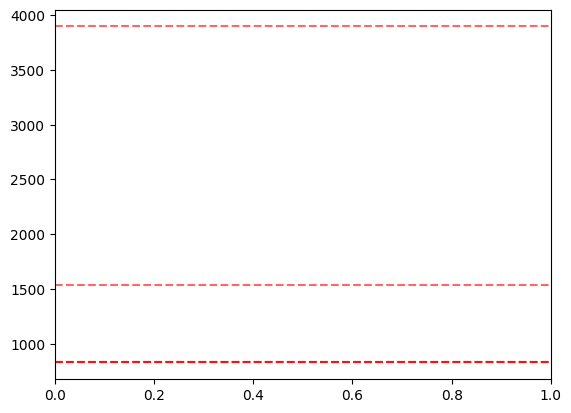

In [26]:
for freq in dominant_frequencies:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.6)
plt.show()

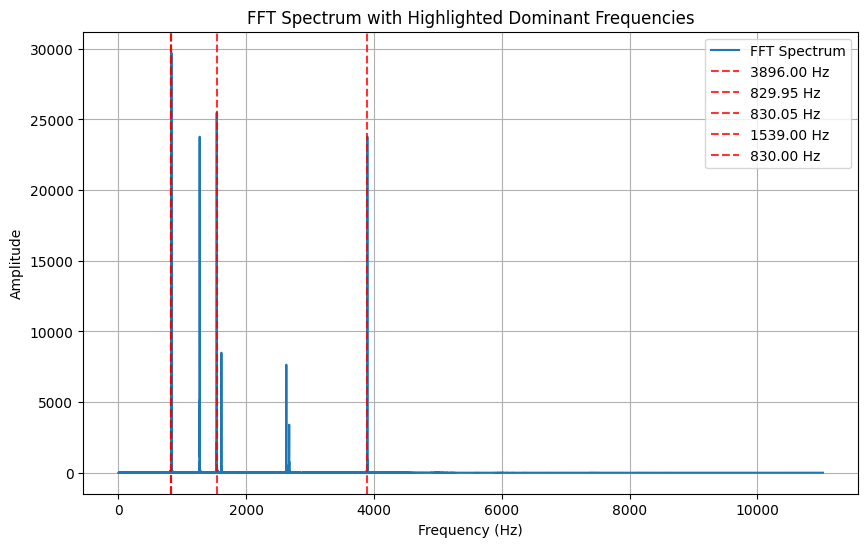

In [27]:
# Highlight dominant frequencies on the plot
plt.figure(figsize=(10, 6))
plt.plot(frequencies, amplitude, label="FFT Spectrum")
for freq in dominant_frequencies:
    plt.axvline(x=freq, color='r', linestyle='--', alpha=0.8, label=f"{freq:.2f} Hz")
plt.title("FFT Spectrum with Highlighted Dominant Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


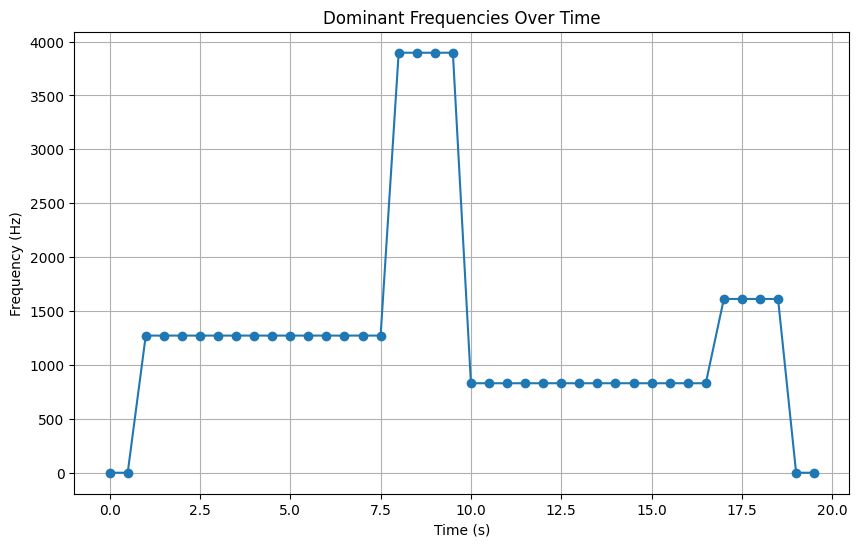

In [28]:
# Segment signal for FFT over time
segment_length = int(sample_rate * 0.5)  # 0.5-second segments
num_segments = len(y) // segment_length
time = np.arange(num_segments) * 0.5

# Compute dominant frequency per segment
dominant_frequencies_over_time = []
for i in range(num_segments):
    segment = y[i * segment_length:(i + 1) * segment_length]
    fft_values = np.fft.rfft(segment)
    frequencies = np.fft.rfftfreq(len(segment), d=1/sample_rate)
    amplitudes = np.abs(fft_values)
    dominant_frequencies_over_time.append(frequencies[np.argmax(amplitudes)])

# Plot dominant frequencies over time
plt.figure(figsize=(10, 6))
plt.plot(time, dominant_frequencies_over_time, marker='o', linestyle='-')
plt.title("Dominant Frequencies Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid()
plt.show()

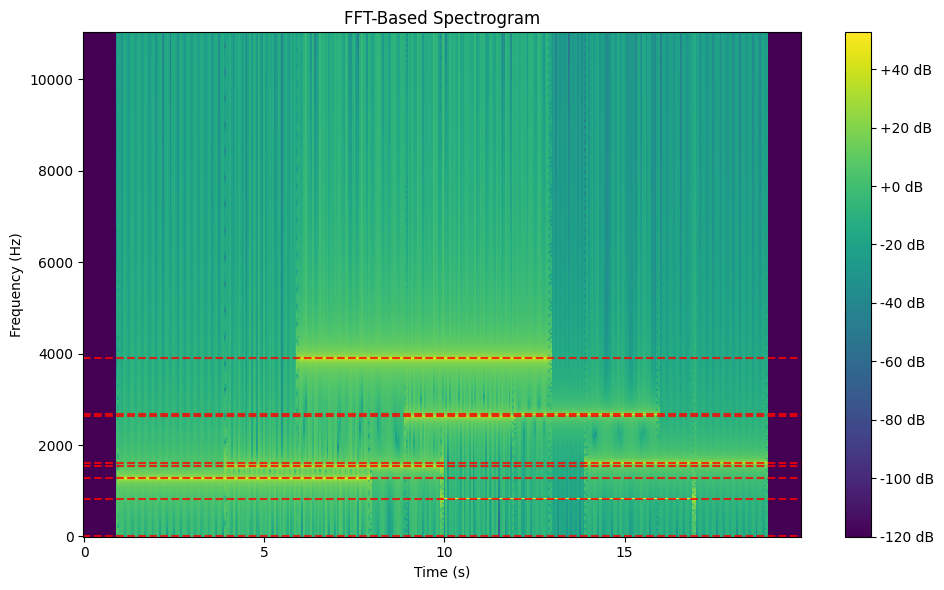

In [29]:
# Define parameters for segmentation
segment_length = int(sample_rate * 0.1)  # 0.1-second segments
overlap = segment_length // 2  # 50% overlap
step = segment_length - overlap
num_segments = (len(y) - segment_length) // step + 1
time = np.arange(num_segments) * (step / sample_rate)

# Compute frequencies for FFT
frequencies = np.fft.rfftfreq(segment_length, d=1/sample_rate)

# Compute spectrogram using FFT
spectrogram = []
for i in range(num_segments):
    start = i * step
    segment = y[start:start + segment_length]
    fft_segment = np.abs(np.fft.rfft(segment))
    spectrogram.append(fft_segment)

# Convert to a 2D array and normalize in decibels
spectrogram = np.array(spectrogram).T
spectrogram_db = 20 * np.log10(spectrogram + 1e-6)

plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis="time", y_axis="hz", cmap="viridis", hop_length=step)
plt.colorbar(format="%+2.0f dB")
plt.title("FFT-Based Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

for freq in unique_frequencies:
    plt.axhline(y=freq, color="red", linestyle="--", alpha=0.8)

plt.tight_layout()
plt.show()


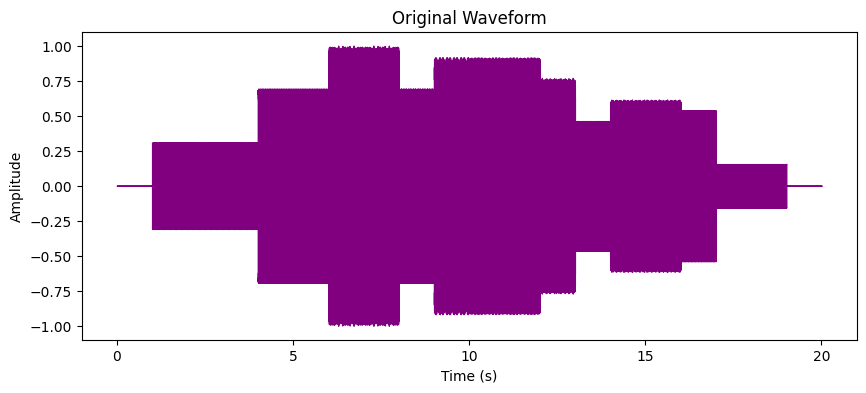

In [30]:
plt.figure(figsize=(10, 4))
dsp.waveshow(y, sr=sample_rate, color='purple')
plt.title("Original Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

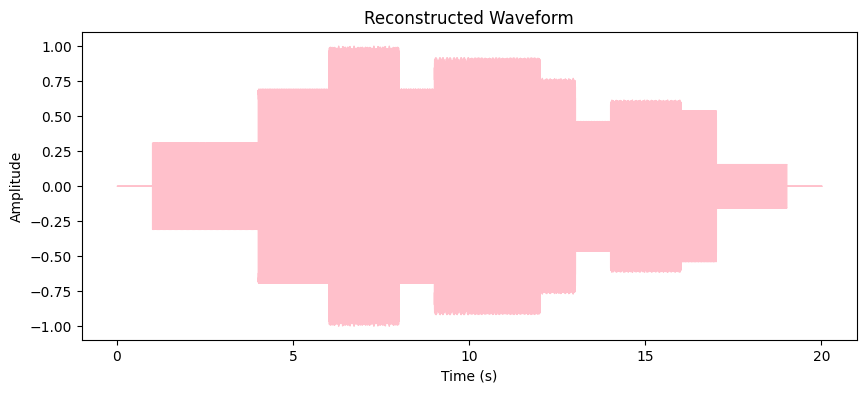

In [31]:
plt.figure(figsize=(10, 4))
dsp.waveshow(mixture, sr=sample_rate, color='pink')
plt.title("Reconstructed Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

##### Question 4 [15 points]
Resample your file so that only three or four different frequencies remain. Resample down and then back up to the original sample rate.

Hint:
- https://librosa.org/doc/main/generated/librosa.resample.html
- How can we see the frequencies?
- What is the relationship between the sample rate and the maximum frequency detectable?

#### Answer:
By applying Fourier transformation as shown earlier, we are able to observe the frequencies. Concerning the relationship between the sampling rate and the maximum frequency, in theory, the highest frequency that can be represented is half of the sampling rate (this is known as the Nyquist frequency). However, in practical situations, the actual limit is slightly lower.

In [32]:
# Calculate current unique frequencies
data_list = frequencies_amplitudes

# Extract all keys (frequencies) from the dictionaries, excluding zeros
all_frequencies = set()
for frequency_dict in data_list:
    all_frequencies.update(f for f in frequency_dict.keys() if f != 0.0)

# Display the set of unique frequencies
all_frequencies

{830.0, 1272.0, 1539.0, 1612.0, 2628.0, 2673.0, 3896.0}

In [33]:
print(f"The original signal contains {len(all_frequencies)} unique frequencies.")

The original signal contains 7 unique frequencies.


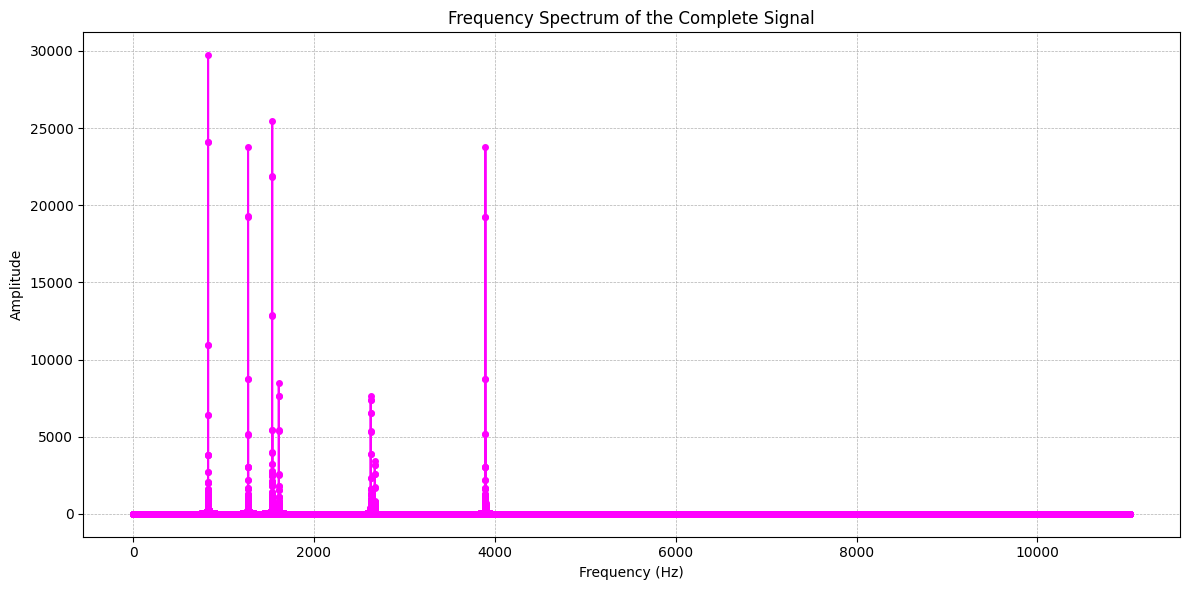

In [34]:
# Compute the Fourier Transform of the signal 'y'
fourier_transform = np.fft.rfft(y)
frequency_axis = np.fft.rfftfreq(len(y), d=1.0 / sample_rate)

plt.figure(figsize=(12, 6))
plt.plot(frequency_axis, np.abs(fourier_transform), color='magenta', linestyle='-', marker='o', markersize=4)
plt.title("Frequency Spectrum of the Complete Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


In [35]:
# Resample down
new_sample_rate = sample_rate // 6
print(f"New sample rate after downsampling: {new_sample_rate} Hz")

New sample rate after downsampling: 3675 Hz


In [36]:
# Resample the original signal 'y' to the new sample rate using librosa
y_downsampled = librosa.resample(y, orig_sr=sample_rate, target_sr=new_sample_rate)

# Calculate the length of the downsampled signal divided by 20
samples_per_segment = y_downsampled.shape[0] / 20
print(f"Samples per segment: {samples_per_segment}")

Samples per segment: 3675.0


In [37]:
# Obtain frequencies and amplitudes from the downsampled signal
freq_amp_downsampled = get_amplitudes_frequencies(y_downsampled, new_sample_rate)

# Display the frequencies and amplitudes of the downsampled signal
print("Frequencies and amplitudes of the downsampled signal:")
freq_amp_downsampled

Frequencies and amplitudes of the downsampled signal:


[{0.0: 0.0},
 {1272.0: 566.1236518561367},
 {1272.0: 566.147449543093},
 {1272.0: 566.2086190949442},
 {1272.0: 566.0863045963132, 1539.0: 707.5959091383644},
 {1272.0: 566.1478406493195, 1539.0: 707.682187089252},
 {1272.0: 566.1470384022471, 1539.0: 707.6865853734856},
 {1272.0: 566.1236514900964, 1539.0: 707.6527954714903},
 {1539.0: 707.7171425938334},
 {1539.0: 707.610225845498},
 {830.0: 707.7110505642744},
 {830.0: 707.6810047284663},
 {830.0: 707.6863581198536},
 {830.0: 707.7030850722174},
 {830.0: 707.6664383445975, 1612.0: 283.0159964270324},
 {830.0: 707.6827486529655, 1612.0: 283.07456231396475},
 {830.0: 707.6776623481496, 1612.0: 283.0555747758494},
 {1612.0: 283.09106781490686},
 {1612.0: 283.0159815403525},
 {0.0: 0.0}]

In [38]:
# Collect all unique frequencies from the resampled data
unique_frequencies_downsampled = set()
for freq_amp_dict in freq_amp_downsampled:
    unique_frequencies_downsampled.update(freq for freq in freq_amp_dict.keys() if freq != 0.0)
unique_frequencies_downsampled

{830.0, 1272.0, 1539.0, 1612.0}

In [39]:
# Display the number of unique frequencies in the resampled signal
print(f"The resampled signal contains {len(unique_frequencies_downsampled)} unique frequencies.")

The resampled signal contains 4 unique frequencies.


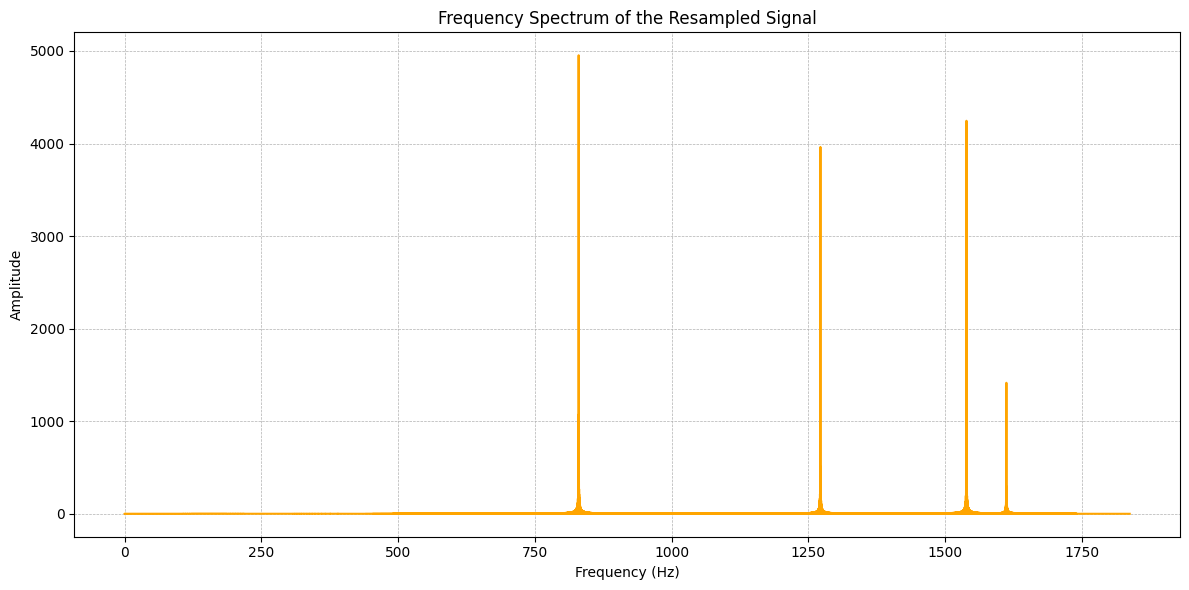

In [40]:
# Compute the Fourier Transform of the downsampled signal
fft_downsampled = np.fft.rfft(y_downsampled)
frequency_axis_downsampled = np.fft.rfftfreq(y_downsampled.size, d=1.0 / new_sample_rate)

# Plot the frequency spectrum of the resampled signal with a new design
plt.figure(figsize=(12, 6))
plt.plot(frequency_axis_downsampled, np.abs(fft_downsampled), color='orange', linewidth=1.5)

# Customize the plot
plt.title("Frequency Spectrum of the Resampled Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

In [41]:
# Determine the maximum frequency from the set of unique frequencies in the downsampled signal
max_frequency_downsampled = max(unique_frequencies_downsampled)

# Calculate the ratio of the maximum frequency to the new sample rate
frequency_sample_rate_ratio = max_frequency_downsampled / new_sample_rate
print(f"Maximum frequency to sample rate ratio: {frequency_sample_rate_ratio}")

Maximum frequency to sample rate ratio: 0.43863945578231295


#### In practical terms, the highest frequency that can be accurately represented is slightly less than half the sampling rate.

In [42]:
# Resample back
# Display the number of unique frequencies in the downsampled signal
print(f"The downsampled signal contains {len(unique_frequencies_downsampled)} unique frequencies.")

The downsampled signal contains 4 unique frequencies.


In [43]:
# Upsample the downsampled signal back to the original sample rate
y_upsampled = librosa.resample(y_downsampled, orig_sr=new_sample_rate, target_sr=sample_rate)

# Calculate the number of samples per segment in the upsampled signal
samples_per_segment_upsampled = y_upsampled.shape[0] / 20
print(f"Samples per segment after upsampling: {samples_per_segment_upsampled}")

Samples per segment after upsampling: 22050.0


In [44]:
# Collect frequencies and amplitudes from the upsampled signal
freq_amp_upsampled = get_amplitudes_frequencies(y_upsampled, sample_rate)

# Display the frequencies and amplitudes of the upsampled signal
print("Frequencies and amplitudes of the upsampled signal:")
freq_amp_upsampled

Frequencies and amplitudes of the upsampled signal:


[{0.0: 0.0},
 {1272.0: 3396.794480039463},
 {1272.0: 3396.88495224402},
 {1272.0: 3397.0861320028152},
 {1272.0: 3396.6835289353025, 1539.0: 4245.7326749075455},
 {1272.0: 3396.818615961881, 1539.0: 4245.996447964015},
 {1272.0: 3396.9510212836976, 1539.0: 4246.217430074899},
 {1272.0: 3396.7945259594994, 1539.0: 4245.94578654115},
 {1539.0: 4246.139452488258},
 {1539.0: 4245.956883608094},
 {830.0: 4246.173123867852},
 {830.0: 4246.12171523902},
 {830.0: 4246.120997476128},
 {830.0: 4246.120396826432},
 {830.0: 4246.056830462106, 1612.0: 1698.1839646407307},
 {830.0: 4246.1133405338, 1612.0: 1698.497064273855},
 {830.0: 4246.068600513817, 1612.0: 1698.2677319103236},
 {1612.0: 1698.5628966000613},
 {1612.0: 1698.183960163245},
 {0.0: 0.0}]

In [45]:
# Extract unique frequencies from the upsampled signal's frequency-amplitude data
unique_frequencies_upsampled = set()
for freq_amp_dict in freq_amp_upsampled:
    unique_frequencies_upsampled.update(freq for freq in freq_amp_dict.keys() if freq != 0.0)

# Display the unique frequencies in the upsampled signal
print("Unique frequencies in the upsampled signal:")
print(unique_frequencies_upsampled)

Unique frequencies in the upsampled signal:
{1272.0, 1539.0, 1612.0, 830.0}


In [46]:
print(f"The upsampled signal contains {len(unique_frequencies_upsampled)} unique frequencies.")

The upsampled signal contains 4 unique frequencies.


##### Question 5 [15 points]
Generate phase for your file using GriffinLim.
Show the following:
- Your waveform after stft and then istft
- Your waveform after 0 iteration of GL
- Your waveform after GL
- The difference between the original and the 0 iter version
- The difference between the original and the GM version
- The difference between the original and the stft-istft version
 - Note that doing STFT and back looses some information so you may need to crop your original vector to match the sizes

Hint:
- https://librosa.org/doc/main/generated/librosa.griffinlim.html
- How can we see the frequencies?
- What is the relationship between the sample rate and the maximum frequency detectable?

In [47]:
signal_length = len(y)
fft_size = 2048

# Zero-pad the original signal to accommodate the STFT window size
y_padded = librosa.util.fix_length(y, size=signal_length + fft_size // 2)

# Compute the Short-Time Fourier Transform (STFT)
stft_data = librosa.stft(y_padded, n_fft=fft_size)

# Perform the inverse STFT to reconstruct the signal
y_reconstructed = librosa.istft(stft_data, length=signal_length)

In [48]:
# Compute the magnitude spectrogram of the original signal
magnitude_spectrogram = np.abs(librosa.stft(y))

# Griffin-Lim algorithm with 0 iterations (initial phase estimation)
y_griffinlim_zero_iter = librosa.griffinlim(magnitude_spectrogram, n_iter=0)

# Griffin-Lim algorithm with default iterations (32 by default)
y_griffinlim = librosa.griffinlim(magnitude_spectrogram)

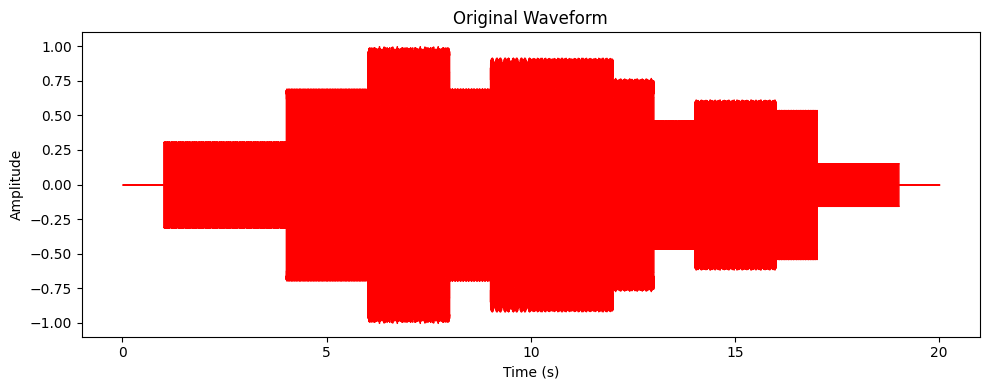

In [49]:
# Plot the original waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sample_rate, color='r')
plt.title("Original Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [50]:
# Play the original audio
Audio(data=y, rate=sample_rate)

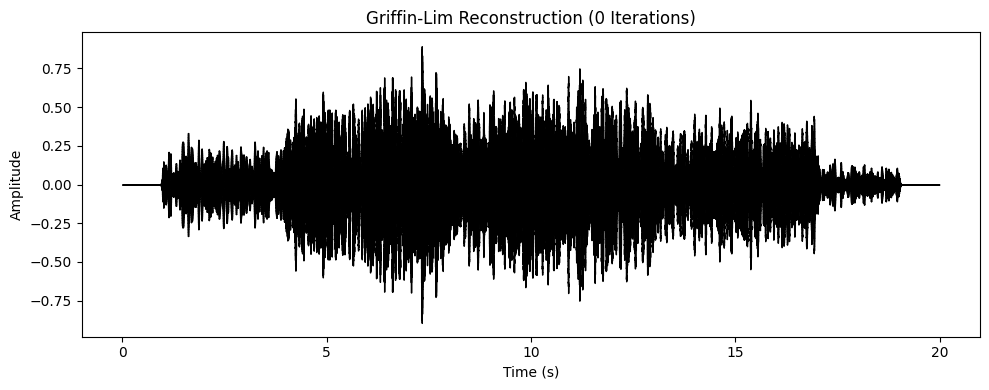

In [51]:
# Plot the Griffin-Lim 0 iteration waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_griffinlim_zero_iter, sr=sample_rate, color='black')
plt.title("Griffin-Lim Reconstruction (0 Iterations)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [52]:
# Play the Griffin-Lim 0 iteration audio
Audio(data=y_griffinlim_zero_iter, rate=sample_rate)

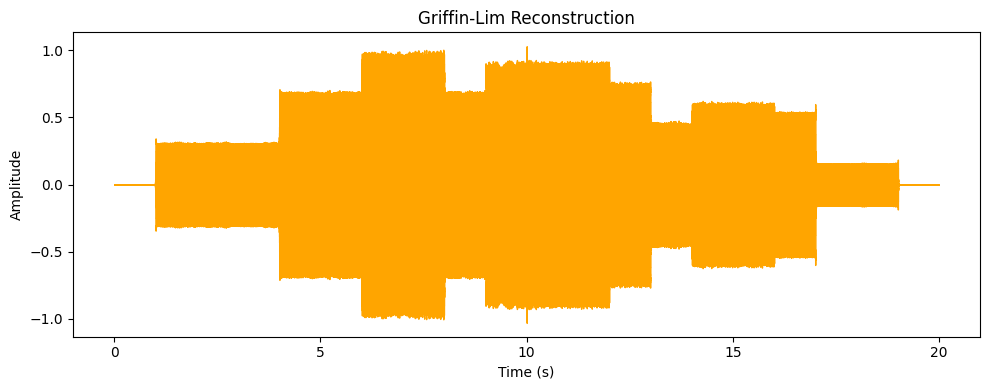

In [53]:
# Plot the Griffin-Lim waveform with iterations
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_griffinlim, sr=sample_rate, color='orange')
plt.title("Griffin-Lim Reconstruction")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [54]:
# Play the Griffin-Lim reconstructed audio
Audio(data=y_griffinlim, rate=sample_rate)

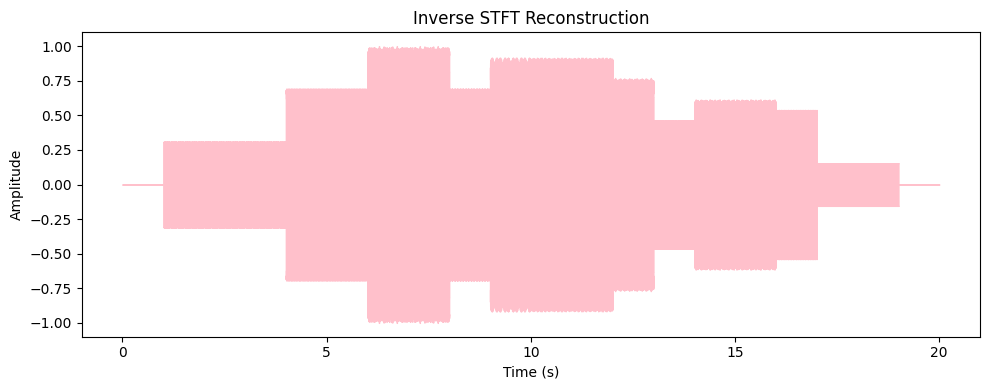

In [55]:
# Plot the inverse STFT (perfect reconstruction) waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_reconstructed, sr=sample_rate, color='pink')
plt.title("Inverse STFT Reconstruction")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [56]:
# Play the inverse STFT audio
Audio(data=y_reconstructed, rate=sample_rate)

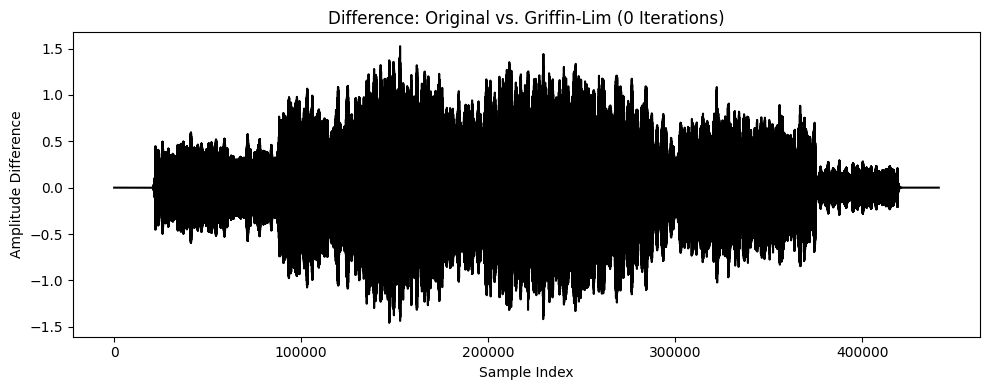

In [57]:
# Calculate differences between the original and reconstructed signals
optimal_diff = y - y_reconstructed
diff_original_griffinlim_zero = y[:len(y_griffinlim_zero_iter)] - y_griffinlim_zero_iter
diff_original_griffinlim = y[:len(y_griffinlim)] - y_griffinlim

# Plot the difference between original and Griffin-Lim 0 iteration reconstruction
plt.figure(figsize=(10, 4))
plt.plot(diff_original_griffinlim_zero, color='black')
plt.title("Difference: Original vs. Griffin-Lim (0 Iterations)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Difference")
plt.tight_layout()
plt.show()

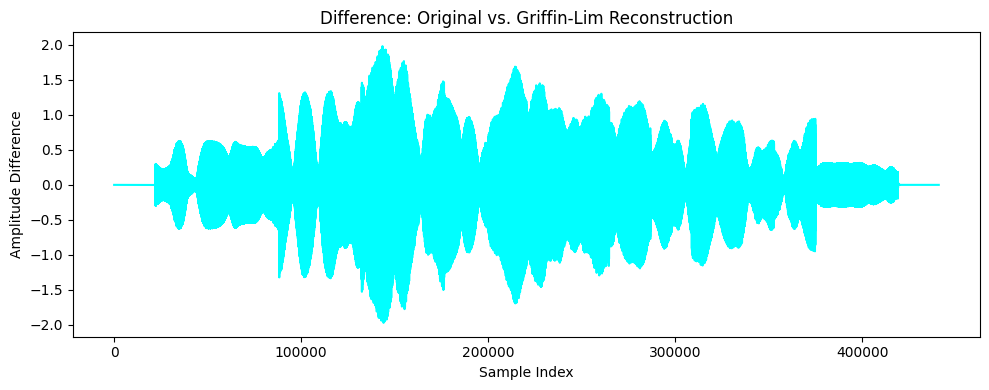

In [58]:
# Plot the difference between original and Griffin-Lim reconstruction
plt.figure(figsize=(10, 4))
plt.plot(diff_original_griffinlim, color='cyan')
plt.title("Difference: Original vs. Griffin-Lim Reconstruction")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Difference")
plt.tight_layout()
plt.show()

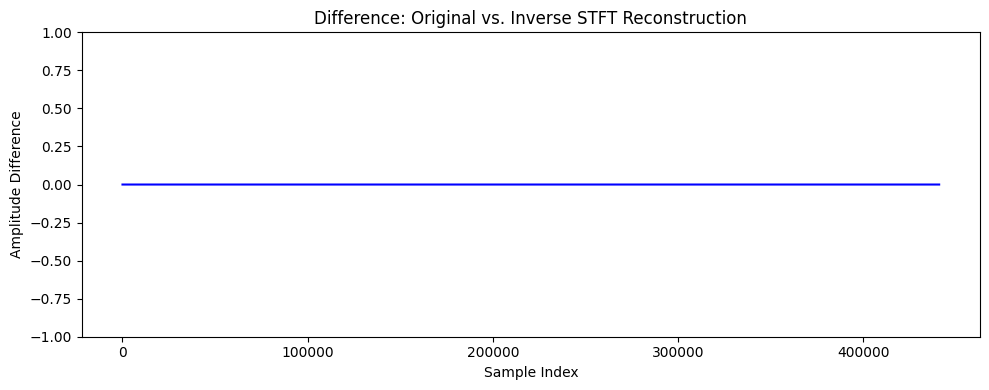

In [59]:
# Plot the difference between original and inverse STFT reconstruction
plt.figure(figsize=(10, 4))
plt.plot(optimal_diff, color='blue')
plt.title("Difference: Original vs. Inverse STFT Reconstruction")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude Difference")
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [60]:
# Calculate and display the maximum absolute difference for the perfect reconstruction
max_diff_perfect = np.max(np.abs(optimal_diff))
print(f"Maximum absolute difference (perfect reconstruction): {max_diff_perfect}")

Maximum absolute difference (perfect reconstruction): 1.7881393432617188e-07


##### Question 6 [10 points]

Describe the difference between the Griffith & Lim and the perfect reconstruction. Does it sound similar? Can you see the difference in the waveform?

### Answer:
#### The Griffiths-Lim algorithm begins with random phase estimates and alternates between forward and inverse STFT operations. It aims for a perfect reconstruction using the inverse STFT by minimizing the mean squared error between the `stft_matrix` and the STFT of the reconstructed signal, `y`.

#### In our approach, Griffiths-Lim reconstruction sounds almost identical to the perfect reconstruction and the original audio, making it difficult to perceive differences by ear. However, when comparing the waveforms, noticeable differences emerge. The perfect reconstruction waveform closely matches the original waveform, with only negligible discrepancies. In contrast, Griffiths-Lim approximates the phase, and the difference between its reconstruction and the original signal becomes clearly visible when analyzed.

##### Question 7 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 6.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

https://drive.google.com/file/d/1nk2sJl2HBRa1_8yNmYrCW_cEeBNpmpj8/view?usp=sharing